<h1 style="font-size:2.0em; font-weight:bold; text-align:center;">Feature Engineering</h1>



The dataset spans from **April 2, 2025** to **April 4, 2025**, based on the assumption that mid-2025 trade tensions lead to an increase in abnormal or suspicious transaction activities.

For **Feature Engineering**, we handled numerical and categorical variables separately with the following steps: 

- Train-test split: perform feature engineering on each dataset.
- Handle missing values.
- Create new features.
- Apply feature transformations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np

In [2]:
df = pd.read_csv('data/EDA_transaction_monitoring_merged.csv')

In [65]:
df.shape

(10609, 41)

**Train-Test Split**

As `is_fraud` is imbalanced, so we use `StratifiedShuffleSplit()` to maintain the same ratio of predictor classes.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Define the feature columns
feature_cols = X.columns    

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_idx, test_idx in strat_shuf_split.split(X, y):
  X_train = df.loc[train_idx, feature_cols]
  y_train = df.loc[train_idx, 'is_fraud']

  X_test  = df.loc[test_idx, feature_cols]
  y_test  = df.loc[test_idx, 'is_fraud']

In [5]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (7426, 40)
Shape of X_test: (3183, 40)
Shape of y_train: (7426,)
Shape of y_test: (3183,)


In [6]:
y_train.value_counts(normalize=True)

is_fraud
0    0.98007
1    0.01993
Name: proportion, dtype: float64

In [7]:
y_test.value_counts(normalize=True)

is_fraud
0    0.979893
1    0.020107
Name: proportion, dtype: float64

## <h2 style="font-size: 1.8em; font-weight: bold;"> Feature Engineering in the Training Set </h2>

## <h3 style="font-size: 1.6em; font-weight: bold;"> 1. Handling Missing Values </h2>

In [8]:
feature_na = [feature for feature in X_train if X_train[feature].isnull().sum()>1] 
feature_na

['card_number', 'message', 'own_message']

As discovered in the EDA, most of the columns with missing values are categorical, so we will replace them with a new label, 'missing'.

In [9]:
#Drop or fill with 0 for columns that show no meaningful correlation with the target variable.
for feature in feature_na: 
  X_train[feature_na] = X_train[feature_na].fillna ('missing') 

In [10]:
X_train.isnull().sum().unique()

array([0], dtype=int64)

In this project, there are no missing numeric values. But if there were, we’d use the median or mode to fill them in, since we found outliers during EDA.

## <h2 style="font-size: 1.6em; font-weight: bold;"> 2. New Features Creation </h2>

**Numeric Features**

In [11]:
continuous_features = X_train.select_dtypes(include=['float']).columns.to_list()
continuous_features 

['amount_eur',
 'available_balance_eur',
 'value_dated_balance_eur',
 'credit_limit_eur',
 'total_volume_eur',
 'avg_amount_eur',
 'max_amount_eur',
 'min_amount_eur']

Globally compare patterns (across all transactions).

In [12]:
global_txn_amount = X_train['amount_eur'].median()
X_train['is_txn_above'] = (X_train['amount_eur'] > global_txn_amount).astype(int)

total_txn_amount = X_train['total_volume_eur'].median()
X_train['is_total_txn_above'] = (X_train['total_volume_eur'] > total_txn_amount).astype(int)

Local Analysis. 

In [13]:
X_train['balance_use_pct'] = round(X_train['amount_eur'] *100.00 / X_train['value_dated_balance_eur'],2) 
X_train['limit_use_pct'] = round(X_train['amount_eur']*100.00 / X_train['credit_limit_eur'],2) 
X_train['is_above_max'] = ((X_train['amount_eur'] - X_train['max_amount_eur']) >0 ).astype(int)                
X_train['is_below_min'] = ((X_train['amount_eur'] - X_train['min_amount_eur']) < 0 ).astype(int)  
X_train['is_above_avg'] = ((X_train['amount_eur'] - X_train['avg_amount_eur']) >0 ).astype(int)      

**Temporal Features (Datetime)**

In [14]:
X_train.rename(columns= {'latest_transaction_booking_date': 'last_booking_date'}, inplace=True)

In [15]:
from pandas.api.types import is_datetime64_any_dtype

date_col = []
new_col = []
for col in X_train.columns: 
    if X_train[col].dtypes == 'O':
      try:
         convert = pd.to_datetime(X_train[col])
         if is_datetime64_any_dtype(convert):
            if col !='dob':
             new_col = col+'time'
             X_train.rename(columns= {col:new_col},inplace=True)
             date_col.append(new_col)
      except Exception: 
         continue
print (date_col)

['transaction_datetime', 'value_datetime', 'payment_datetime', 'booking_datetime', 'last_booking_datetime', 'last_transaction_datetime']


In [16]:
new_date_col = []
for col in date_col[:]:
    X_train[col] = pd.to_datetime(X_train[col])
    if col != 'dob':
      X_train[col + '_day'] = X_train[col].dt.day
      X_train[col + '_weekday'] = X_train[col].dt.day_of_week
      X_train[col + '_hour'] = X_train[col].dt.hour
      new_date_col.extend([col + '_day', col + '_weekday', col + '_hour'])

print(new_date_col)

['transaction_datetime_day', 'transaction_datetime_weekday', 'transaction_datetime_hour', 'value_datetime_day', 'value_datetime_weekday', 'value_datetime_hour', 'payment_datetime_day', 'payment_datetime_weekday', 'payment_datetime_hour', 'booking_datetime_day', 'booking_datetime_weekday', 'booking_datetime_hour', 'last_booking_datetime_day', 'last_booking_datetime_weekday', 'last_booking_datetime_hour', 'last_transaction_datetime_day', 'last_transaction_datetime_weekday', 'last_transaction_datetime_hour']


`age`

In [17]:
from datetime import datetime
X_train['dob'] = pd.to_datetime(X_train['dob'])
today = datetime.today()
X_train['age'] = (
    today.year - X_train['dob'].dt.year -
    ((X_train['dob'].dt.month > today.month) | 
     ((X_train['dob'].dt.month == today.month) & (X_train['dob'].dt.day > today.day)))
)

`split_payment`

To flag `split_payment`, we applied business rules to identify accounts that show any of these signs:

- Made multiple payments within a single day.

- Had repeated or similar transaction amounts

- Made more than a set number of payments (high frequency).

In [18]:
# Case 1: Made multiple payments within a single day
time_diff = X_train.groupby('customer_id')['transaction_datetime'].diff()
X_train['is_sequential']= (time_diff <= pd.Timedelta(days=1)).astype(int)

# Case 2: Had repeated or similar transaction amounts
X_train['is_repeated_amount'] = X_train.groupby('customer_id')['amount_eur'].transform(
    lambda x: x.duplicated(keep=False)
).astype(int)

# Case 3: Made more than 3 payments (high frequency)
X_train['is_high_frequency'] = (X_train['transaction_count'] >= 10).astype(int)

In [19]:
count_is_sequential = X_train['is_sequential'].value_counts()
count_is_repeated_amount = X_train['is_repeated_amount'].value_counts()
count_is_high_frequency = X_train['is_high_frequency'].value_counts()

print (count_is_sequential, count_is_repeated_amount,count_is_high_frequency)

is_sequential
1    5573
0    1853
Name: count, dtype: int64 is_repeated_amount
0    7426
Name: count, dtype: int64 is_high_frequency
1    5474
0    1952
Name: count, dtype: int64


It seems that we don't have any transactions with repeated amounts, so we should drop this feature as it adds no weight to our model.

In [20]:
X_train.drop(columns='is_repeated_amount', inplace=True)

## <h2 style="font-size: 1.6em; font-weight: bold;"> 3. Feature Transformation </h2>

**3.1 Continuous Variable**

In [21]:
continuous_feature = X_train.select_dtypes(include='float').columns.to_list()
print(continuous_feature)

['amount_eur', 'available_balance_eur', 'value_dated_balance_eur', 'credit_limit_eur', 'total_volume_eur', 'avg_amount_eur', 'max_amount_eur', 'min_amount_eur', 'balance_use_pct', 'limit_use_pct']


As discovered during EDA, most numerical variables are skewed and require transformation.

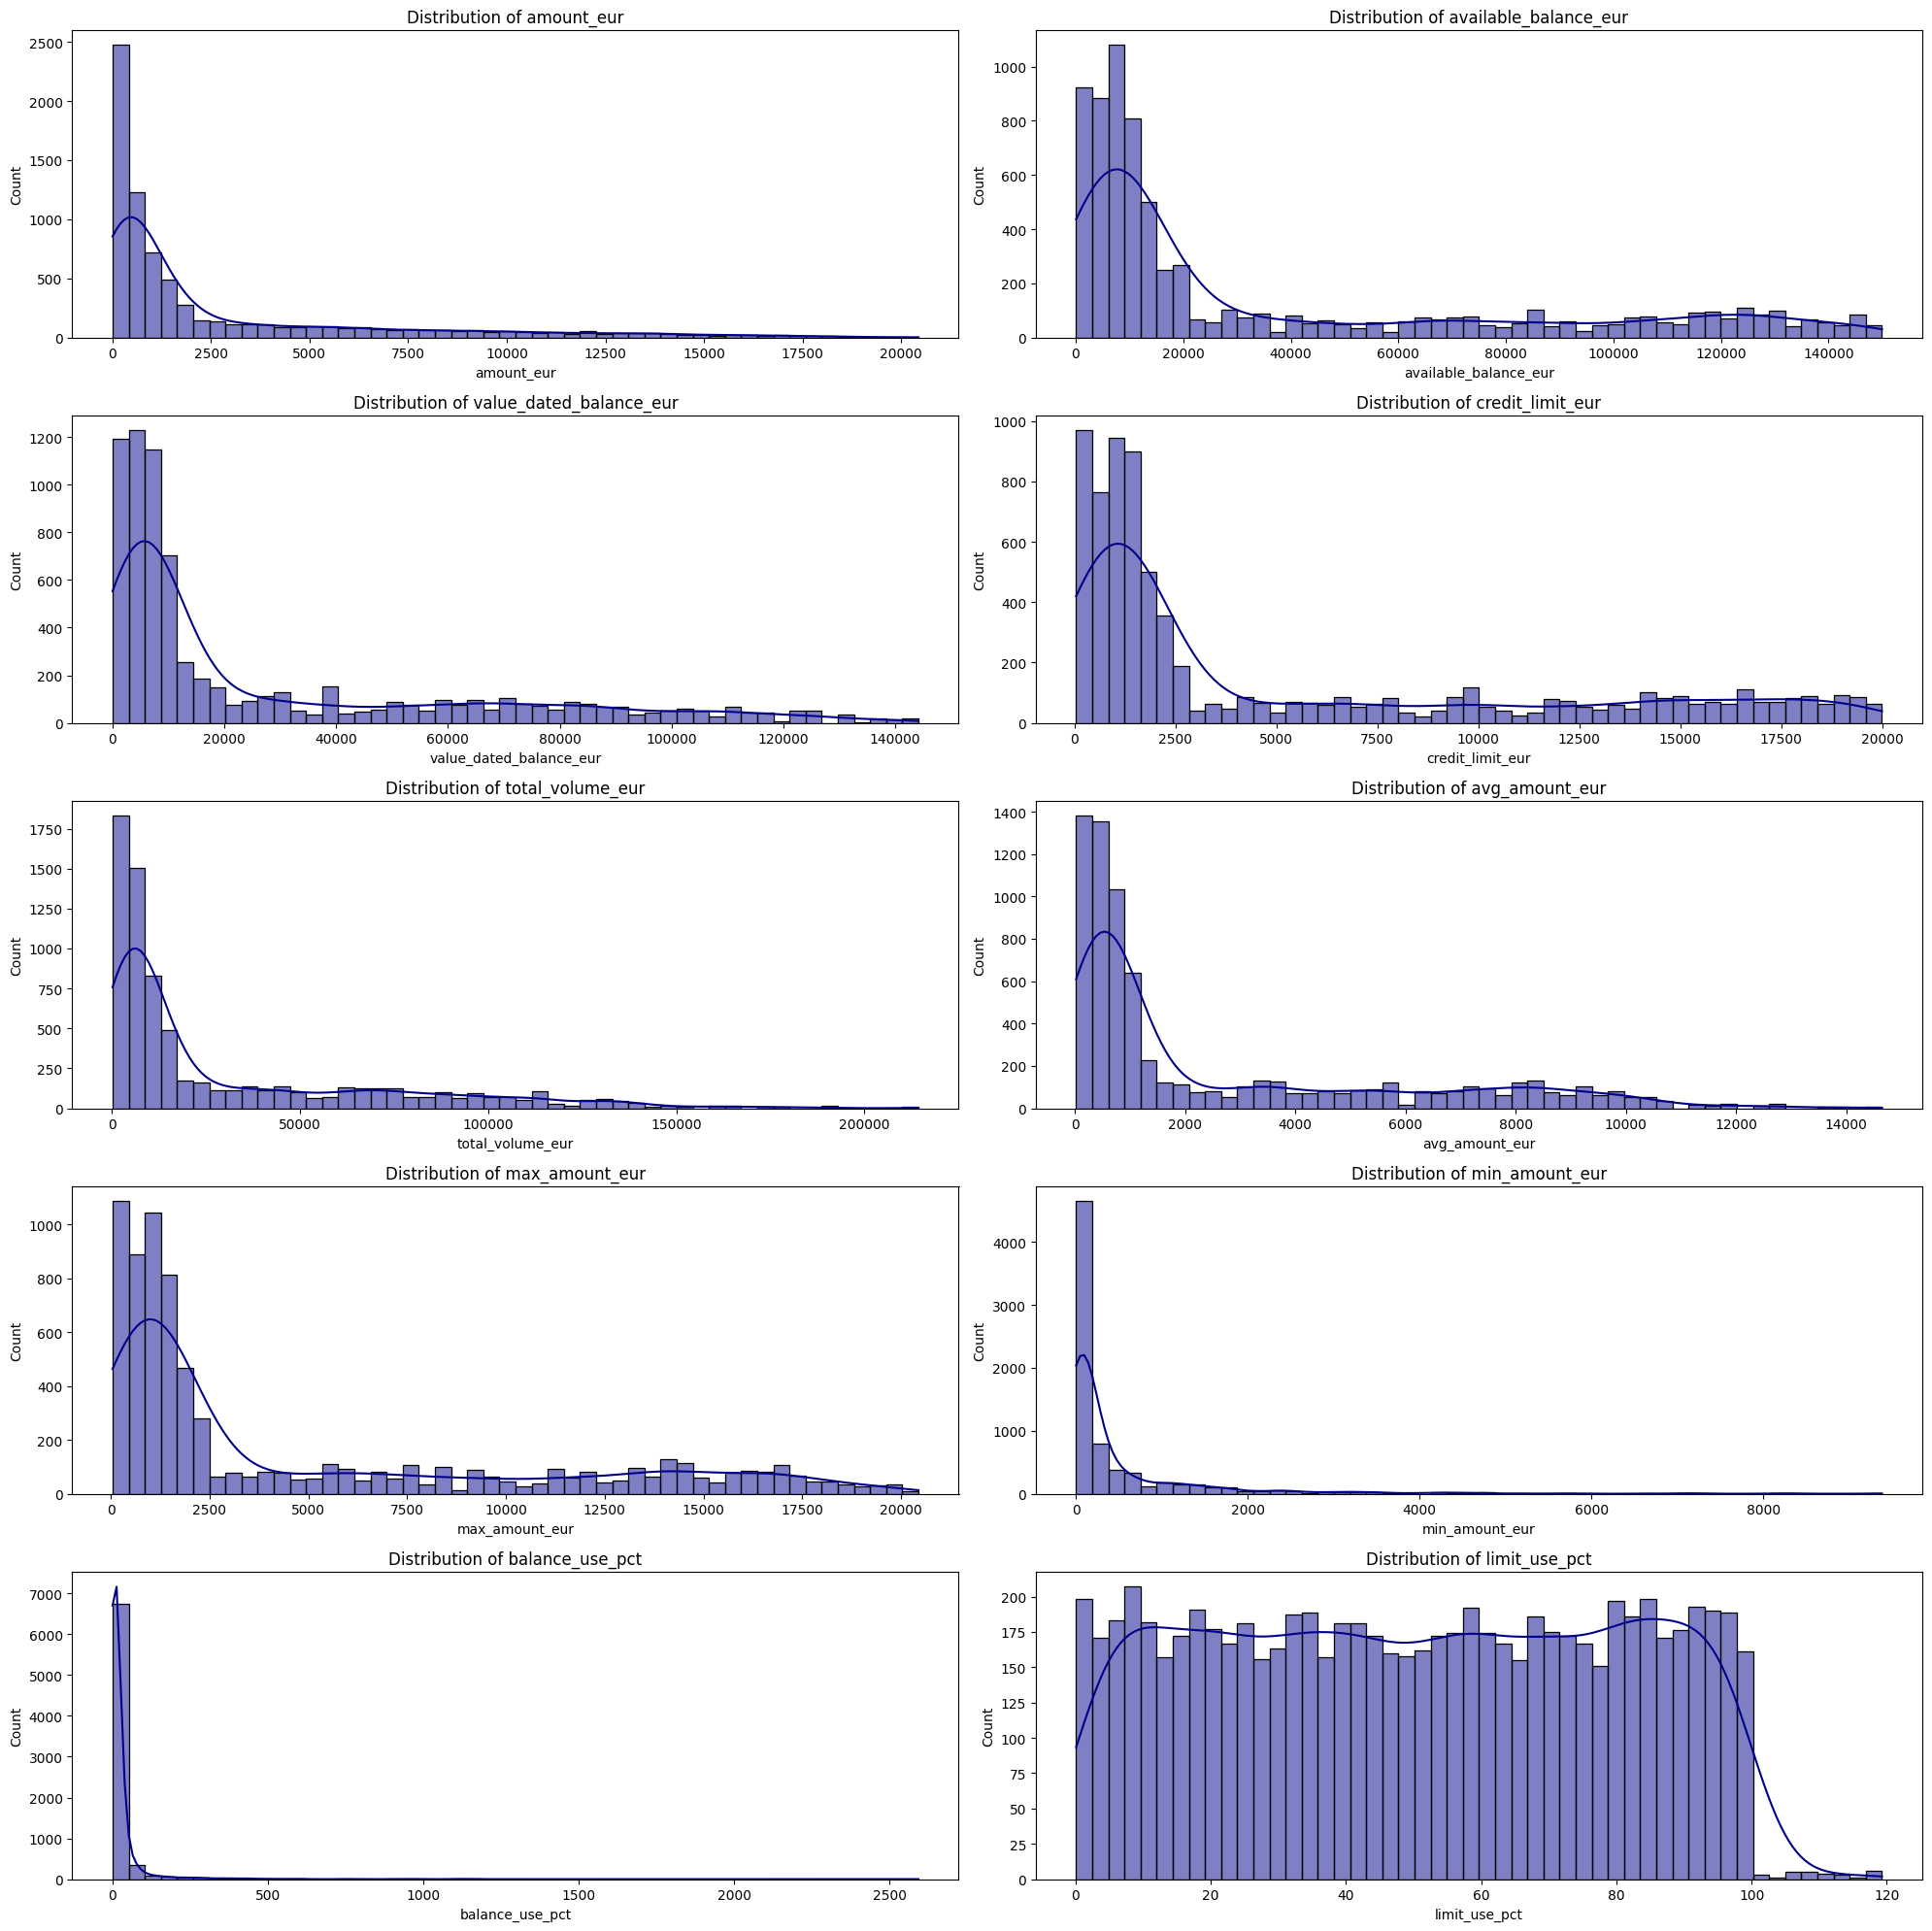

In [22]:
plt.figure(figsize=(20, 20))
for i, col in enumerate(continuous_feature,1):
      X_train_copy = X_train.copy()
      plt.subplot(5, 2, i)
      sns.histplot(X_train_copy[col], bins=50, kde=True, color='darkblue')
      plt.title(f'Distribution of {col}')
      plt.xlabel(col)
      plt.ylabel('Count')

plt.tight_layout()
plt.show()

Let's apply log transformation.

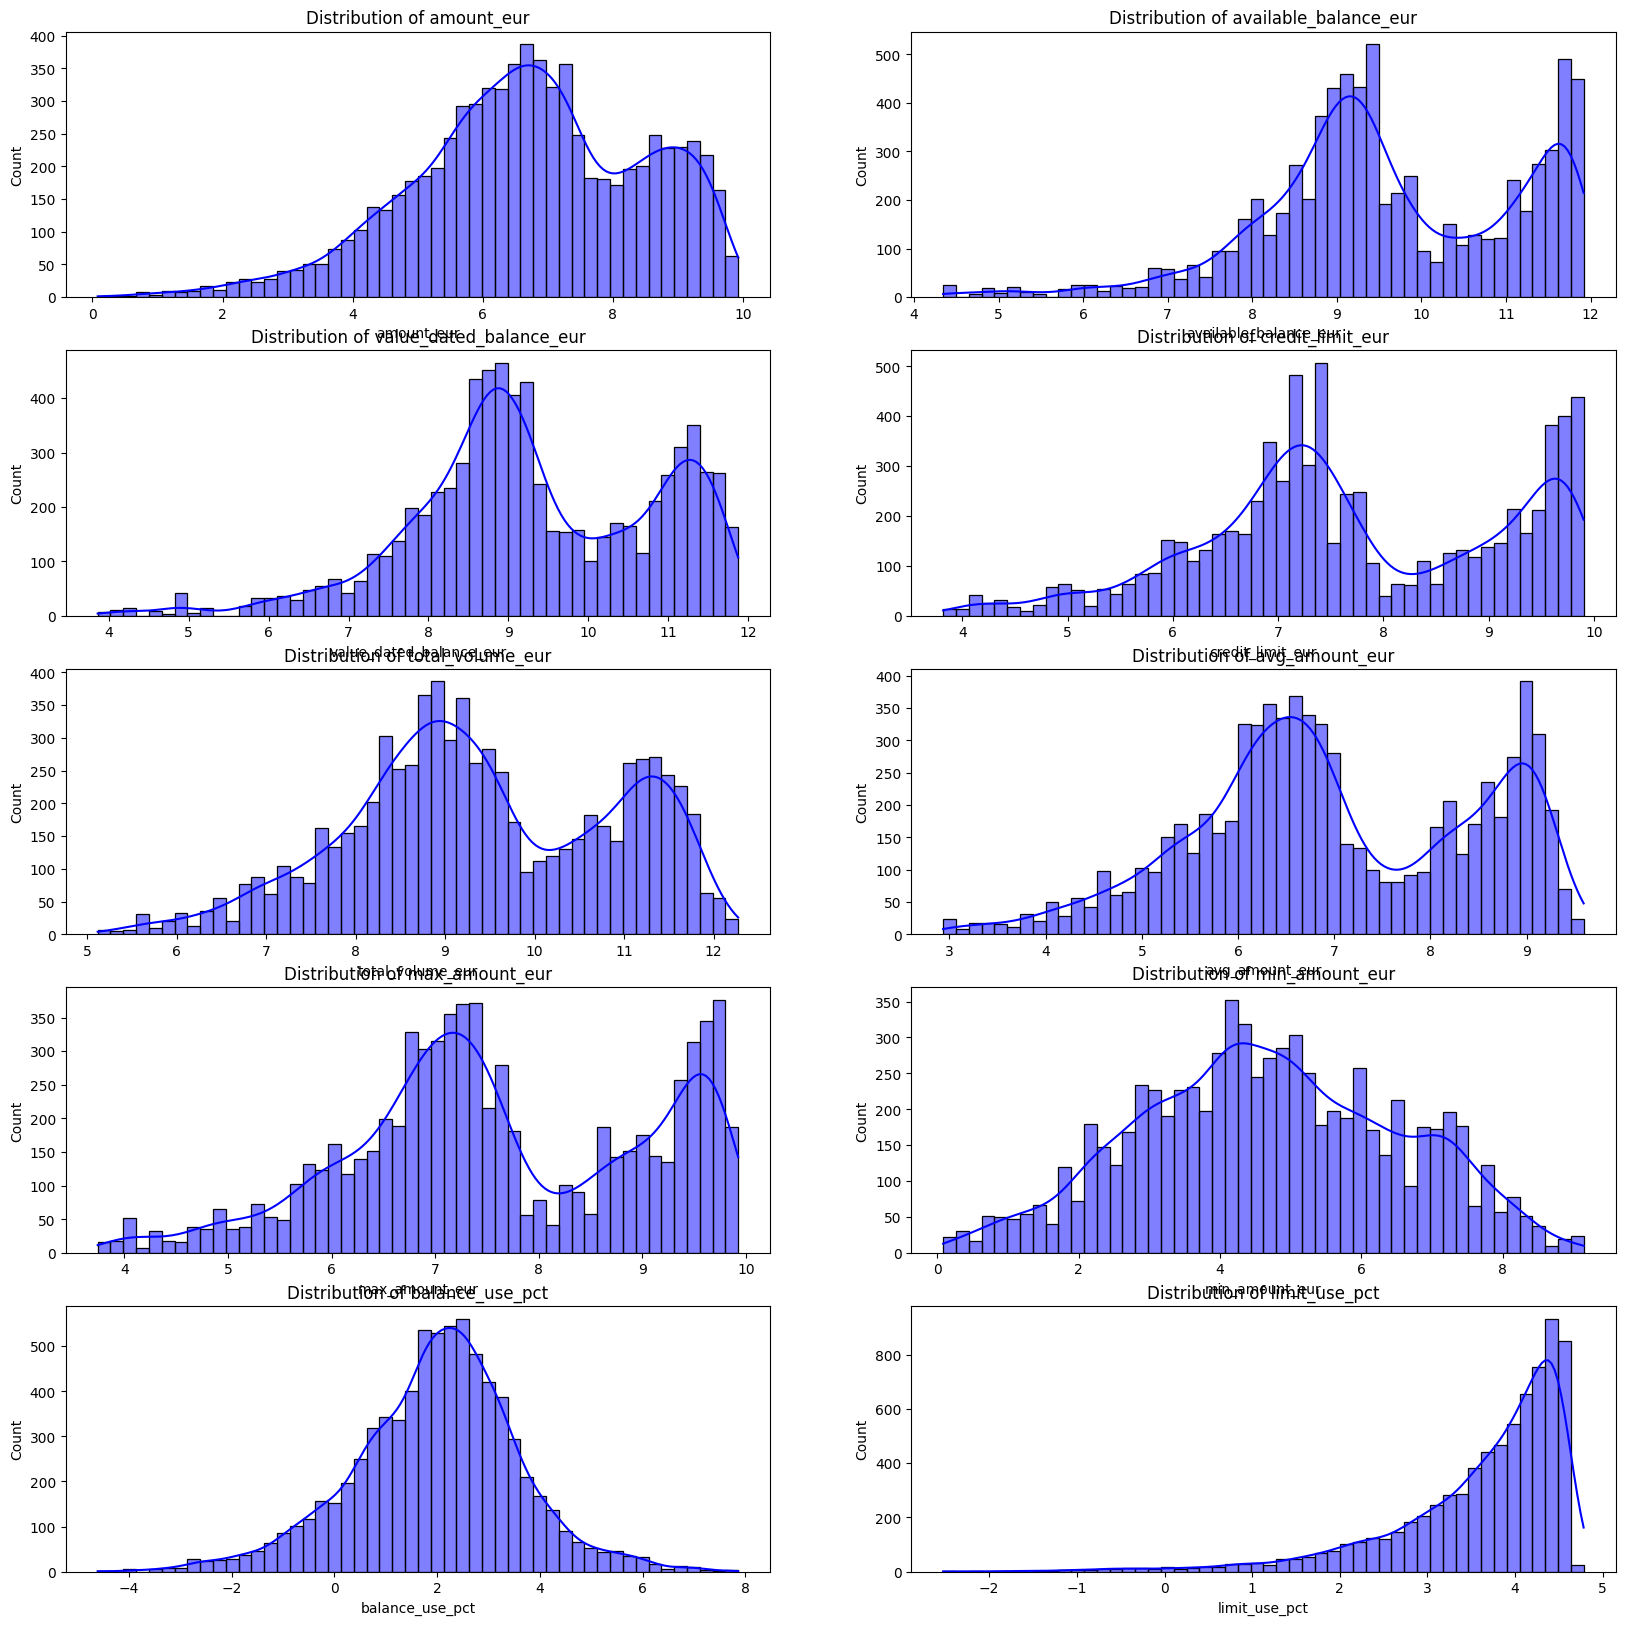

In [23]:

from numpy import log

plt.figure(figsize=(20, 20))
for i, col in enumerate(continuous_feature,1):
    X_train_copy = X_train.copy()
    if 0 in X_train_copy[col].unique():
        pass
    else:
       X_train_copy[col] = np.log(X_train_copy[col])
       plt.subplot(5, 2, i)
       sns.histplot(X_train_copy[col], bins=50, kde=True, color='blue')
       plt.title(f'Distribution of {col}')
       plt.xlabel(col)
       plt.ylabel('Count')

 

Let's try applying the Box-Cox transformation.

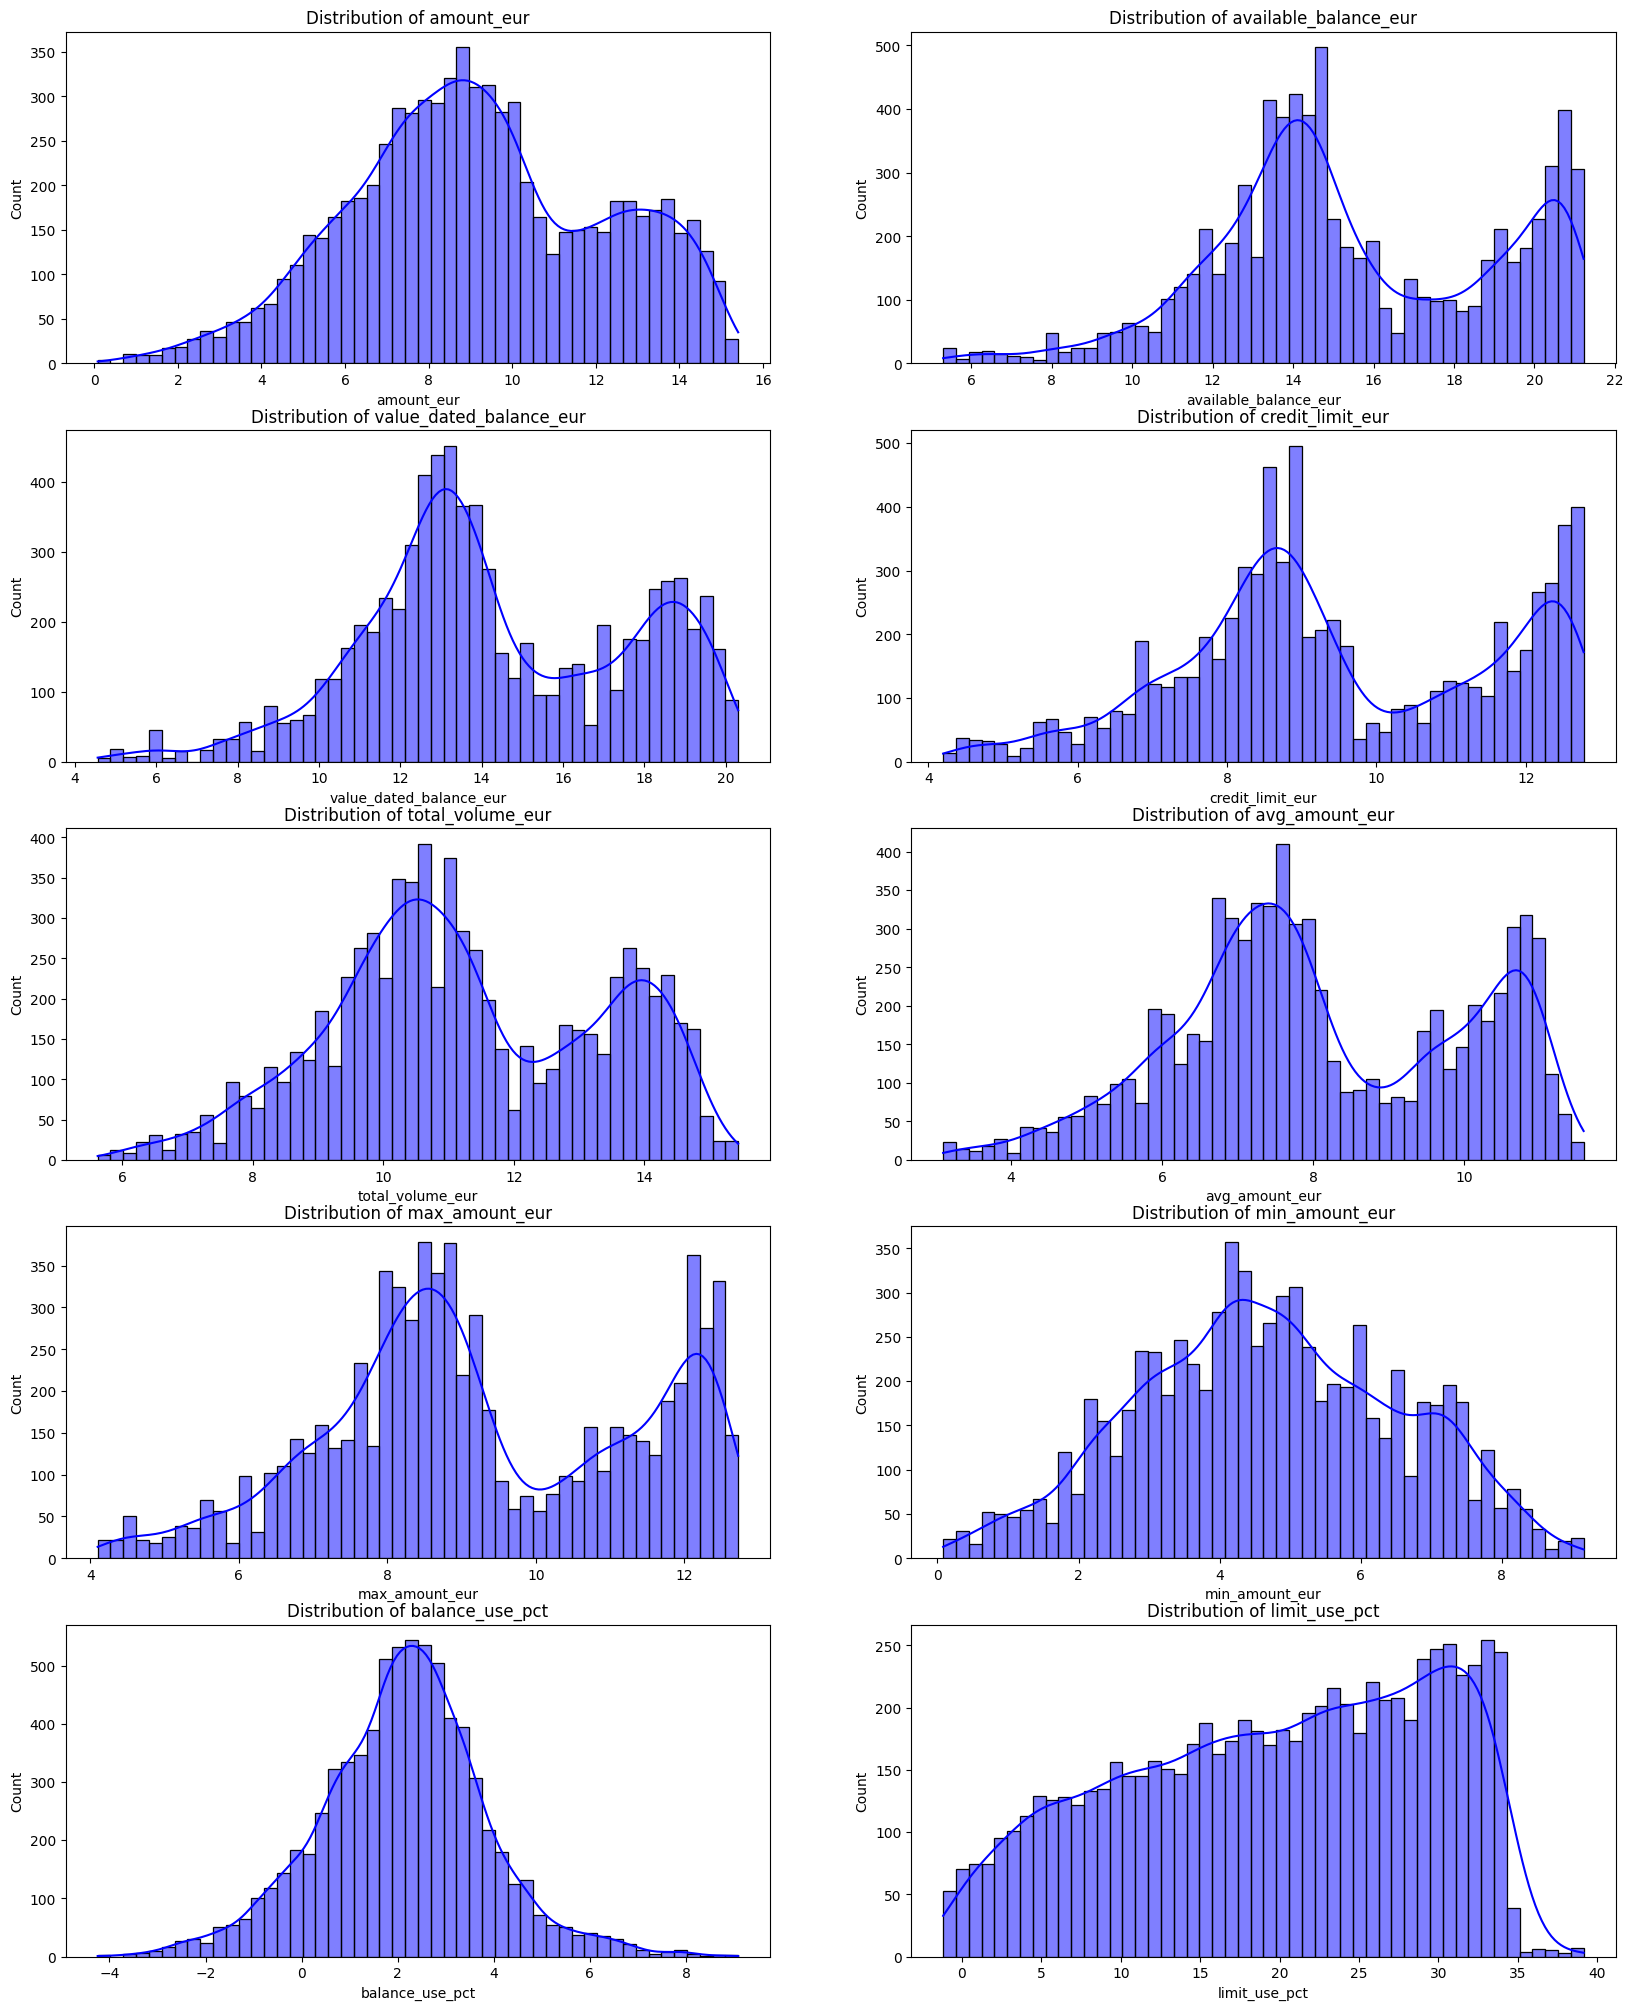

In [24]:
from scipy.stats import boxcox

plt.figure(figsize=(20, 25))
for i, col in enumerate(continuous_feature,1):
    if 0 in X_train[col].unique():
        pass
    else:
       bc_result,_ = boxcox(X_train[col])
       plt.subplot(5, 2, i)
       sns.histplot(bc_result, bins=50, kde=True, color='blue')
       plt.title(f'Distribution of {col}')
       plt.xlabel(col)
       plt.ylabel('Count')

It seems there isn’t much difference when applying Box-Cox or log transformation to our dataset, except for `limit_use_pct`, which shows better results

In [25]:
for col in continuous_feature:
    if 0 in X_train[col].values:
        continue  
    else:
        X_train[col], _ = boxcox(X_train[col])

**3.2 Categorical Feature**

In [26]:
categorical_feature = X_train.select_dtypes(include='object').columns.to_list()

#Identify the number of unique categories in each categorical (object) column.
for feature in categorical_feature: 
    count_value = X_train[feature].value_counts()
    print (feature,'-', len(count_value),'categories')


customer_id - 1000 categories
transaction_id - 7426 categories
currency - 4 categories
type_description - 5 categories
transaction_type - 5 categories
narrative - 6971 categories
status_x - 1 categories
counterparty_name - 6108 categories
card_number - 1473 categories
message - 2 categories
own_message - 2 categories
country - 5 categories
account_numbers - 1000 categories
account_name - 997 categories
product - 3 categories
account_type - 2 categories
status_y - 1 categories
registration_number - 1000 categories
residence_country - 5 categories
occupation - 10 categories
gender - 3 categories
bank.name - 1 categories
bank.bic - 1 categories
bank.country - 5 categories


In [27]:
drop_col = []
date_col = ['transaction_date', 'booking_date', 'value_date', 'payment_date']
for feature in categorical_feature: 
    count_value = X_train[feature].value_counts() 
    if len(count_value) >= 900 or len (count_value) == 1:
      drop_col.append(feature)
    if feature in date_col:
      drop_col.append(feature)
print(drop_col)

['customer_id', 'transaction_id', 'narrative', 'status_x', 'counterparty_name', 'card_number', 'account_numbers', 'account_name', 'status_y', 'registration_number', 'bank.name', 'bank.bic']


In [28]:
categorical_feature = [col for col in categorical_feature if col not in drop_col]

*Rare Categorical Feature*

We will lable 'rare_var' for categorical variables that appear in less than 1% of the observations, as they carry little significance for the analysis.

In [29]:
for feature in categorical_feature:
      counts = X_train[feature].value_counts()
      rare_categories = counts[counts < len(df) * 0.01].index
      X_train[feature] = X_train[feature].apply(lambda x: 'rare_var' if x in rare_categories else x)

In [30]:
X_train[categorical_feature].nunique()

currency              4
type_description      5
transaction_type      5
message               2
own_message           2
country               5
product               3
account_type          2
residence_country     5
occupation           10
gender                3
bank.country          5
dtype: int64

In [31]:
#high_card_feature = []
#for feature in categorical_features: 
    #if feature not in drop_col:
     #count_value = categorical_features[feature].value_counts()
     #if len(count_value) > 10:
       #high_card_feature.append(feature)


In [32]:
##for feature in high_card_feature:
      #labels_ordered = df.groupby([feature])['is_fraud'].mean().sort_values().index
      #labels_ordered = {k: i for i, k in enumerate(labels_ordered, 0)}
      #df[feature] = df[feature].map(labels_ordered)
#df[high_card_feature].nunique()

In [33]:
#from sklearn.model_selection import KFold

#from sklearn.model_selection import KFold

#kf = KFold(n_splits=5, shuffle=True, random_state=42)

#for feature in high_card_feature:
    #if feature not in drop_col:
        #df[feature] = np.nan  # clear column to store encoded values

        #for train_idx, val_idx in kf.split(df):
            #means = df.iloc[train_idx].groupby(feature)['is_fraud'].mean()
            #df.loc[df.index[val_idx], feature] = df.loc[df.index[val_idx], feature].map(means)

        #df[feature].fillna(df['is_fraud'].mean(), inplace=True)

#df[high_card_feature].nunique()


In [34]:
#Collect high-cardinality features that have no relationship with is_fraud into a drop list
#for feature in high_card_feature:
  #if df[feature].nunique() == 1 and df[feature].unique()[0] == 0:
        #drop_col.append(feature)
#print(drop_col)

**3.3 Final Transformation**

- For Continuous features, as they contain outliers, we will use RobustScaler() for feature scalling. 

- For categorical features, after eliminating rare values, we will apply one-hot encoding.

In [35]:
X_train[categorical_feature] = X_train[categorical_feature].astype(str)

In [36]:
datetime_col = X_train.select_dtypes(include='datetime').columns.to_list()

In [37]:
numeric_feature = X_train.select_dtypes(include=['float', 'int']).columns.to_list()

In [38]:
print(len(categorical_feature), len(numeric_feature), len(datetime_col), len(drop_col))

12 37 7 12


In [39]:
drop_col.extend(datetime_col)

In [40]:
X_train.drop(columns=drop_col, inplace=True)

In [41]:
X_train.shape

(7426, 49)

In [42]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
numerical_transformer = Pipeline(steps=[('scaler', RobustScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_feature),
        ('num', numerical_transformer, numeric_feature)
    ],
    remainder='passthrough' 
)

X_train_processed = preprocessor.fit_transform(X_train)

feature_names = list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_feature)) 
feature_names.extend(numeric_feature)
data = pd.DataFrame(X_train_processed, columns=feature_names)


In [43]:
data.to_csv('data/CLEAN_transaction_monitoring_merged_X_TRAIN.csv', index=False)

We’ll repeat all the steps for X_test to avoid data leak.

In [44]:
feature_na = [feature for feature in X_test if X_test[feature].isnull().sum()>1] 
for feature in feature_na: 
  X_test[feature_na] = X_test[feature_na].fillna ('missing') 
X_test.isnull().sum().unique()

array([0], dtype=int64)

In [45]:
continuous_features = X_test.select_dtypes(include=['float']).columns.to_list()
global_txn_amount = X_test['amount_eur'].median()
X_test['is_txn_above'] = (X_test['amount_eur'] > global_txn_amount).astype(int)

total_txn_amount = X_test['total_volume_eur'].median()
X_test['is_total_txn_above'] = (X_test['total_volume_eur'] > total_txn_amount).astype(int)

In [46]:
X_test['balance_use_pct'] = round(X_test['amount_eur'] *100.00 / X_test['value_dated_balance_eur'],2) 
X_test['limit_use_pct'] = round(X_test['amount_eur']*100.00 / X_test['credit_limit_eur'],2) 
X_test['is_above_max'] = ((X_test['amount_eur'] - X_test['max_amount_eur']) >0 ).astype(int)                
X_test['is_below_min'] = ((X_test['amount_eur'] - X_test['min_amount_eur']) < 0 ).astype(int)  
X_test['is_above_avg'] = ((X_test['amount_eur'] - X_test['avg_amount_eur']) >0 ).astype(int)      

In [47]:
X_test.rename(columns= {'latest_transaction_booking_date': 'last_booking_date'}, inplace=True)

from pandas.api.types import is_datetime64_any_dtype

date_col = []
new_col = []
for col in X_test.columns: 
    if X_test[col].dtypes == 'O':
      try:
         convert = pd.to_datetime(X_test[col])
         if is_datetime64_any_dtype(convert):
            if col !='dob':
             new_col = col+'time'
             X_test.rename(columns= {col:new_col},inplace=True)
             date_col.append(new_col)
      except Exception: 
         continue
print (date_col)

['transaction_datetime', 'value_datetime', 'payment_datetime', 'booking_datetime', 'last_booking_datetime', 'last_transaction_datetime']


In [48]:
new_date_col = []
for col in date_col[:]:
    X_test[col] = pd.to_datetime(X_test[col])
    if col != 'dob':
      X_test[col + '_day'] = X_test[col].dt.day
      X_test[col + '_weekday'] = X_test[col].dt.day_of_week
      X_test[col + '_hour'] = X_test[col].dt.hour
      new_date_col.extend([col + '_day', col + '_weekday', col + '_hour'])

print(new_date_col)

['transaction_datetime_day', 'transaction_datetime_weekday', 'transaction_datetime_hour', 'value_datetime_day', 'value_datetime_weekday', 'value_datetime_hour', 'payment_datetime_day', 'payment_datetime_weekday', 'payment_datetime_hour', 'booking_datetime_day', 'booking_datetime_weekday', 'booking_datetime_hour', 'last_booking_datetime_day', 'last_booking_datetime_weekday', 'last_booking_datetime_hour', 'last_transaction_datetime_day', 'last_transaction_datetime_weekday', 'last_transaction_datetime_hour']


In [49]:
from datetime import datetime
X_test['dob'] = pd.to_datetime(X_test['dob'])
today = datetime.today()
X_test['age'] = (
    today.year - X_test['dob'].dt.year -
    ((X_test['dob'].dt.month > today.month) | 
     ((X_test['dob'].dt.month == today.month) & (X_test['dob'].dt.day > today.day)))
)

In [50]:
# Case 1: Made multiple payments within a single day
time_diff = X_test.groupby('customer_id')['transaction_datetime'].diff()
X_test['is_sequential']= (time_diff <= pd.Timedelta(days=1)).astype(int)

# Case 2: Had repeated or similar transaction amounts
X_test['is_repeated_amount'] = X_test.groupby('customer_id')['amount_eur'].transform(
    lambda x: x.duplicated(keep=False)
).astype(int)

# Case 3: Made more than 3 payments (high frequency)
X_test['is_high_frequency'] = (X_test['transaction_count'] >= 10).astype(int)

In [51]:
count_is_sequential = X_test['is_sequential'].value_counts()
count_is_repeated_amount = X_test['is_repeated_amount'].value_counts()
count_is_high_frequency = X_test['is_high_frequency'].value_counts()

print (count_is_sequential, count_is_repeated_amount,count_is_high_frequency)

is_sequential
1    1946
0    1237
Name: count, dtype: int64 is_repeated_amount
0    3183
Name: count, dtype: int64 is_high_frequency
1    2372
0     811
Name: count, dtype: int64


In [52]:
X_test.drop(columns='is_repeated_amount', inplace=True)

In [53]:
for col in continuous_feature:
    if 0 in X_test[col].values:
        continue  
    else:
        X_test[col], _ = boxcox(X_test[col])

In [54]:
for feature in categorical_feature: 
    count_value = X_test[feature].value_counts()
    print (feature,'-', len(count_value),'categories')

currency - 4 categories
type_description - 5 categories
transaction_type - 5 categories
message - 2 categories
own_message - 2 categories
country - 5 categories
product - 3 categories
account_type - 2 categories
residence_country - 5 categories
occupation - 10 categories
gender - 3 categories
bank.country - 5 categories


In [55]:
categorical_feature = X_test.select_dtypes(include='object').columns.to_list()
drop_col = []
date_col = ['transaction_date', 'booking_date', 'value_date', 'payment_date']
for feature in categorical_feature: 
    count_value = X_test[feature].value_counts() 
    if len(count_value) >= 900 or len (count_value) == 1:
      drop_col.append(feature)
    if feature in date_col:
      drop_col.append(feature)
drop_col.append('card_number')
print(drop_col)

['customer_id', 'transaction_id', 'narrative', 'status_x', 'counterparty_name', 'account_numbers', 'account_name', 'status_y', 'registration_number', 'bank.name', 'bank.bic', 'card_number']


In [56]:
categorical_feature = [col for col in categorical_feature if col not in drop_col]

In [57]:
for feature in categorical_feature:
      counts = X_test[feature].value_counts()
      rare_categories = counts[counts < len(df) * 0.01].index
      X_test[feature] = X_test[feature].apply(lambda x: 'rare_var' if x in rare_categories else x)

In [58]:
X_test[categorical_feature].nunique()

currency              4
type_description      5
transaction_type      5
message               2
own_message           2
country               5
product               3
account_type          2
residence_country     5
occupation           10
gender                3
bank.country          5
dtype: int64

In [59]:
X_test[categorical_feature] = X_test[categorical_feature].astype(str)
datetime_col = X_test.select_dtypes(include='datetime').columns.to_list()
numeric_feature = X_test.select_dtypes(include=['float', 'int']).columns.to_list()
print(len(categorical_feature), len(numeric_feature), len(datetime_col), len(drop_col))

12 37 7 12


In [60]:
drop_col.extend(datetime_col)

In [61]:
X_test.drop(columns=drop_col, inplace=True)
X_test.shape

(3183, 49)

In [62]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
numerical_transformer = Pipeline(steps=[('scaler', RobustScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_feature),
        ('num', numerical_transformer, numeric_feature)
    ],
    remainder='passthrough' 
)

X_test_processed = preprocessor.fit_transform(X_test)

feature_names = list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_feature)) 
feature_names.extend(numeric_feature)
data_1 = pd.DataFrame(X_test_processed, columns=feature_names)


In [63]:
data_1.to_csv('data/CLEAN_transaction_monitoring_merged_X_TEST.csv', index=False)